# Seq2Seq File Name Prediction

RJ Joyce and Shreya Shetty Atmakuri

For our project, we built a sequence-to-sequence (seq2seq) autoencoder model that predicts the name of a Python file given its source code. A seq2seq autoencoder is used to convert one type of data sequence into another type. For example, they have commonly been used to translate sentences from one language into another. Our seq2seq autoencoder model will translate from a sequence of tokens from Python source code into a sequence of english characters (the file name).

### Prior Research

As far as we are aware, there are no existing research papers that have attempted this problem. This research could be applicable in many fields, most notably reverse engineering. The ability to automatically generate names for source code files could provide insights into the behaviors that those files perform.

We had originally planned on predicting function names given function contents, but found that a paper by Alon et al. titled "Code2Seq: Generating Sequences From Structured Representations of Code" has already shown success in this area. Alon et al. were able to predict names of Java methods given their contents and were also able to generate a short 'caption' that described a snippet of C# code. Code2Seq has seen major success in embedding code and could be considered a counterpart to Word2Vec, a popular model for embedding text.

Because function calls, if statements, breaks, and other control flow operations influence the order of execution it would be naive to read source code linearly, as one might with text. Furthermore, two areas of code spaced far apart may be related, such as a class definition and an instance of that class. For this reason Code2Seq, as well as our approach, are based on abstract syntax trees (AST) rather than raw tokens. The AST represents the structure of the source code's syntax, providing additonal context to each token.


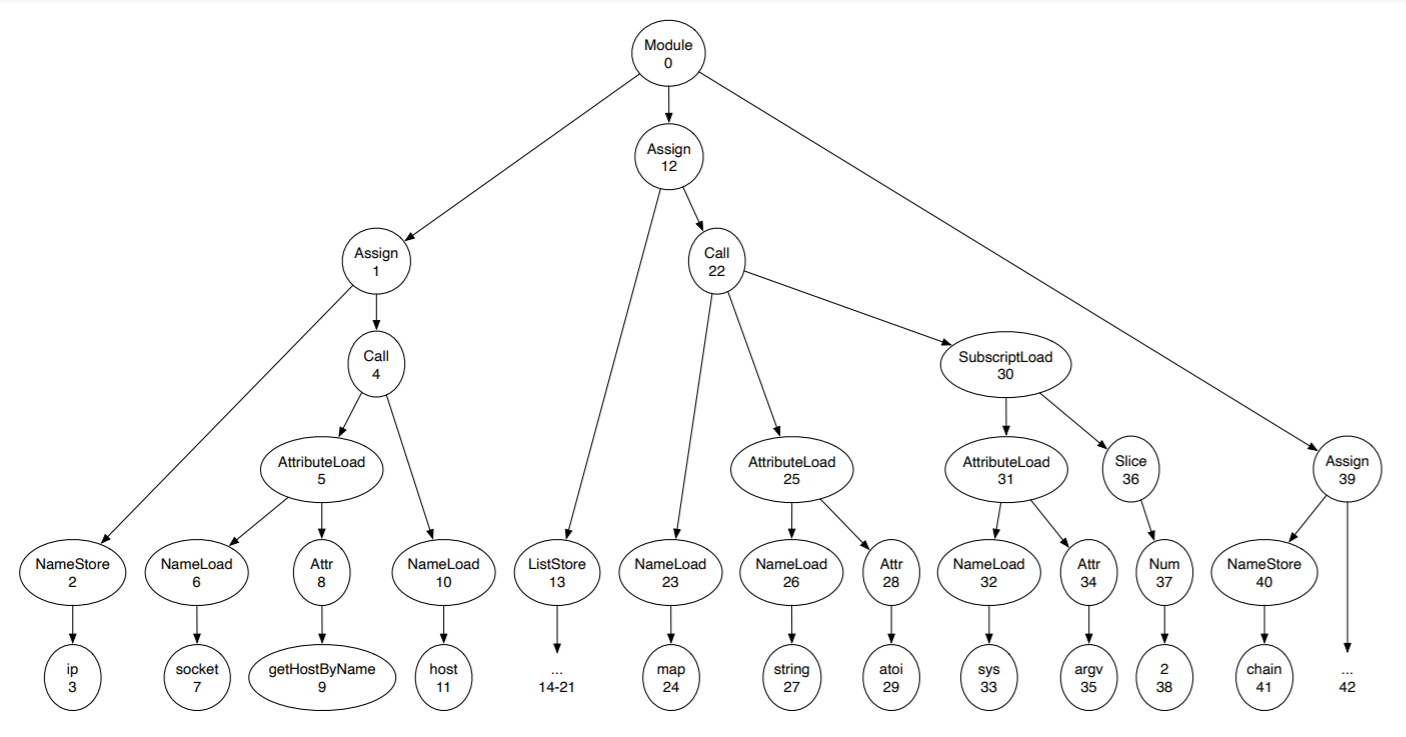


Code2Seq separates the AST into paths and encodes each path using a bi-directional LSTM. Because Code2Seq operates on the scale of AST paths rather than full ASTs we need a new approach for embedding entire source code files. The challenge of representing large ASTs as sequnces is one of the main considerations of the project.

We chose to use the py150k dataset, which includes the source code for 150,000 different Python files on github. The py150k dataset also includes ASTs for each file. It is separated into 100,000 training and 50,000 test samples.

We base our method for embedding entire ASTs on both Code2Seq and a paper by Kim et al. titled "Code Prediction by Feeding Trees to Transformers". Kim et al. make modifications to Code2Seq in order to train a transformer to predict the next token in a Python code snippet. Kim et al. also separate the AST into paths prior to embedding, so their approach cannot be applied directly to our problem. However, they make two notable modifications to Code2Seq that result in significant improvements. First, they restructure the AST to separate nodes that contain both an attribute and a value, and make all values leaf nodes. Second, they propose a new algorithm for creating paths through the AST which they call DFSud. DFSud uses depth first search to create a preorder traversal of the AST. Then, they create paths by selecting two nodes in the AST and finding the shortest path between them.

Although we do not use the Code2Seq or DFSud implementations directly in this work, our model is heavily based on both. Furthermore, Kim et al. have released code for generating modified ASTS, performing depth-first search on ASTS, tokenizing AST values, etc. We use these resources rather than re-implementing them ourselves.

### Preparing the py150k Dataset

Download and extract the py150k dataset
```
wget http://files.srl.inf.ethz.ch/data/py150.tar.gz
wget http://files.srl.inf.ethz.ch/data/py150_files.tar.gz
tar -xvf py150.tar.gz
tar -xvf py150_files.tar.gz
```

Prepare folders for training and testing data + labels
```
mkdir train_data
mkdir test_data
mv python100k_train.txt train_data/filenames.txt
mv python50k_eval.txt test_data/filenames.txt
```

Clone git repo for the "Code Prediction by Feeding Trees to Transformers" paper
```
git clone https://github.com/facebookresearch/code-prediction-transformer.git
```

Generate modified ASTs
```
python3 code-prediction-transformer/generate_new_trees.py --input_fp python100k_train.json --out_fp train_data/asts.json
python3 code-prediction-transformer/generate_new_trees.py --input_fp python50k_eval.json --out_fp test_data/asts.json
```

Generate subtoken vocabulary
```
python3 code-prediction-transformer/code2seq/generate_vocab.py --n_vocab 100000 --vocab_type subtoken --input_fp python100k_train_new.json --out_fp subtoken\
_vocab.pkl
```

### Processing the File Name Data

Import everything, including useful functions from the "Code Prediction by Feeding Trees to Transformers" git repo

In [ ]:
import os
import sys
import json
import pickle
import string
import argparse
import unicodedata
import numpy as np
import seaborn as sns
from itertools import islice

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
sys.path.insert(0, "/content/gdrive/My Drive/MPDL Fall 2020/")
sys.path.insert(0, "/content/gdrive/My Drive/MPDL Fall 2020/code-prediction-transformer")
from utils import line_positions, get_terminal_nodes, tokenize
from code2seq.generate_data import get_word2idx, extract_paths, get_value
from mpdl import *

Mounted at /content/gdrive/


Define global variables for file paths and special tokens, as well as a filename alphabet

In [ ]:
# Make randomness deterministic
torch.backends.cudnn.deterministic=True
set_seed(42)

# Paths to training and testing directories
TRAIN_DIR = "/content/gdrive/My Drive/MPDL Fall 2020/train_data"
TEST_DIR = "/content/gdrive/My Drive/MPDL Fall 2020/test_data"

# These tokens match the ones used by the subtoken vocabulary script
# Also using start and end tokens
UNK = "<unk_token>"
PAD = "<pad_token>"
PLACEHOLDER = "<placeholder_token>"
SOS = "<SOS>"
EOS = "<EOS>"

# Define a vocabulary for the subtokens
IN_VOCAB = get_word2idx("/content/gdrive/My Drive/MPDL Fall 2020/subtoken_vocab.pkl")
IN_VOCAB[SOS] = len(IN_VOCAB.keys())
IN_VOCAB[EOS] = len(IN_VOCAB.keys())

# Define a vocab for the filename alphabet
OUT_VOCAB = {}
FILENAME_ALPHABET = [c for c in string.ascii_letters + " ._-"]
for c in FILENAME_ALPHABET + [PAD, SOS, EOS]:
    OUT_VOCAB[c] = len(OUT_VOCAB.keys())

# Create reverse vocabularies
IN_VOCAB_REV = {v: k for k, v in IN_VOCAB.items()}
OUT_VOCAB_REV = {v: k for k, v in OUT_VOCAB.items()}

# Set training mode
MODES = {"TRAIN_NEW": 0, "WARM_START": 1, "EVAL_ONLY": 2}
TRAIN_MODE = MODES["EVAL_ONLY"]

Read vocab from: /content/gdrive/My Drive/MPDL Fall 2020/subtoken_vocab.pkl


We need to preprocess the file name data inside of filenames.txt and construct a vocabulary. We define functions for these here.

In [ ]:
# unicodeToAscii function from Ch. 4 notebook
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in FILENAME_ALPHABET
    )

# Function for normalizing file names
def normalize_filename(file_path):
    return unicodeToAscii(os.path.basename(file_path))

### Defining the Seq2Seq Dataset Class

Next, we will define a Seq2SeqDataset class that inherits from the PyTorch Dataset class. The class requires a base_dir directory that contains either the modified ASTs or the generated datapoints. If the generated datapoints do not exist, the class will call the generate_data() function to generate the datapoints from the modified ASTs. The class also requires the subtoken vocabulary that we generated and the maximum number of datapoints.

To generate a datapoint, we perform a preorder traversal to flatten the corresponding AST. Due to the size of each AST, we only keep leaf nodes (the nodes containing values rather than attributes). Kim et al. experimented with this modification and found that it was able to significantly shorten the size of paths but also reduced model accuracy because some structural information from the AST is lost. We hope that file name prediction is less sensitive to this information loss than function name predicton because the average datapoint is much larger. We also use this tradeoff so that our model trains faster and has a lower memory footprint. Once the preorder traversal is performed, we tokenize each value and then replace the token with its numeric representation in the vocabulary. We limit the maximum length of a datapoint to 10,000 time steps. It took our code over a day to convert the ASTs into datapoints because of the runtime complexity of depth-first search and the size of the ASTs.

In [ ]:
class Seq2SeqDataset(Dataset):

    def __init__(self, base_dir, n_samples=None):

        # Check required files in base dir
        assert os.path.isdir(base_dir)
        self.asts_path = os.path.join(base_dir, "asts.json")
        self.filenames_path = os.path.join(base_dir, "filenames.txt")
        self.dps_path = os.path.join(base_dir, "dps.txt")
        assert os.path.isfile(self.asts_path) or os.path.isfile(self.dps_path)
        assert os.path.isfile(self.filenames_path)

        # Generate datapoints if file missing
        if not os.path.isfile(self.dps_path):
            print("Generating datapoints")
            self.generate_data()
        else:
            print("Loaded datapoints from {}".format(self.dps_path))

        # Get byte offsets for lines in dps and filename files
        dps_gen = line_positions(self.dps_path)
        filenames_gen = line_positions(self.filenames_path)
        if n_samples is not None:
            self._line_pos_dps = list(islice(dps_gen, n_samples))
            self._line_pos_filenames = list(islice(filenames_gen, n_samples))
        else:
            self._line_pos_dps = list(dps_gen)
            self._line_pos_filenames = list(filenames_gen)


    def __len__(self):
        return len(self._line_pos_dps)

    def __getitem__(self, idx):
        # Get X (AST leaf nodes flattened by DFS)
        line_pos = self._line_pos_dps[idx]
        with open(self.dps_path, "r") as f:
            f.seek(line_pos)
            X = json.loads(f.readline().strip())
            X = [IN_VOCAB[SOS]] + X[:9998] + [IN_VOCAB[EOS]]
            X = torch.tensor(X, dtype=torch.int64)

        # Get y (letters of filename)
        line_pos = self._line_pos_filenames[idx]
        with open(self.filenames_path, "r") as f:
            f.seek(line_pos)
            filename = normalize_filename(f.readline().strip())
            filename = [SOS] + [c for c in filename] + [EOS]
            y = [OUT_VOCAB[c] for c in filename]
            y = torch.tensor(y, dtype=torch.int64)

        return X, y

    def generate_data(self):
        with open(self.asts_path, "r") as f, open(self.dps_path, "w") as f_out:
            for line in f:
                ast = json.loads(line.strip())
                dp = self.get_dp(ast)
                json.dump(dp, f_out)
                f_out.write("\n")

    def get_dp(self, ast):
        # Perform pre-order traversal of modified AST
        paths = extract_paths(ast, 100)
        seen_nodes = set()
        preorder = []
        for path in paths:
            for node in path:
                if node not in seen_nodes:
                    preorder.append(node)
                    seen_nodes.add(node)

        # Only leaf nodes of AST have values
        leaf_nodes = set(get_terminal_nodes(ast))
        preorder = [node for node in preorder if node in leaf_nodes]

        # Tokenize each leaf node's value
        preorder_subtokens = []
        for node in preorder:
            token = get_value(ast[node])
            preorder_subtokens += tokenize(token)

        # Convert tokens to numberic representation using vocabulary 
        dp = [IN_VOCAB[token] for token in preorder_subtokens]
        return dp

We also need a collate function that pads all sequences in a batch to the same length. We use the collate function defined in the Ch. 10 notebook.

In [ ]:
# Collate function based on code from Ch. 10 notebook
def pad_batch(batch):
    max_X = max([i[0].size(0) for i in batch])
    max_y = max([i[1].size(0) for i in batch])
    X = [F.pad(i[0], (0,max_X-i[0].size(0)), value=IN_VOCAB[PAD]) for i in batch]
    y = [F.pad(i[1], (0,max_y-i[1].size(0)), value=OUT_VOCAB[PAD]) for i in batch]
    X, y = torch.stack(X), torch.stack(y)
    return (X, y), y

Now we can initialize train and test datasets and dataloaders for those datasets

In [ ]:
batch_size = 32
train_dataset = Seq2SeqDataset(TRAIN_DIR)
test_dataset = Seq2SeqDataset(TEST_DIR, 10000)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_batch)

Loaded datapoints from /content/gdrive/My Drive/MPDL Fall 2020/train_data/dps.txt
Loaded datapoints from /content/gdrive/My Drive/MPDL Fall 2020/test_data/dps.txt


### Defining the Seq2Seq Autoencoder Model

First we define some helper functions/classes from the Ch. 10 notebook. They include the dot score, which is used for computing the attention scores, the ApplyAttention class, which is the attention mechanism class, the getMaskByFill class, which produces a mask for the padding values, and the CrossEntLossTime function, which is the cross entropy loss modified for working on time sequences.

In [ ]:
# Using the DotScore class from the Ch. 10 notebook
class DotScore(nn.Module):
    def __init__(self, H):
        super(DotScore, self).__init__()
        self.H = H

    def forward(self, states, context):
        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(self.H)
        return scores

# Using the ApplyAttention class from the Ch. 10 notebook
class ApplyAttention(nn.Module):
    def __init__(self):
        super(ApplyAttention, self).__init__()

    def forward(self, states, attention_scores, mask=None):
        if mask is not None:
            attention_scores[~mask] = -1000.0
        weights = F.softmax(attention_scores, dim=1)

        final_context = (states*weights).sum(dim=1)
        return final_context, weights

# Using the getMaskByFill function from Ch. 10 notebook
def getMaskByFill(x, time_dimension=1, fill=0):
    to_sum_over = list(range(1,len(x.shape)))
    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)
    with torch.no_grad():
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

# Using the CrossEntLossTime function from Ch. 10 notebook
def CrossEntLossTime(x, y):
    if isinstance(x, tuple):
        x, _ = x
    cel = nn.CrossEntropyLoss(ignore_index=OUT_VOCAB[PAD])
    T = min(x.size(1), y.size(1))
    loss = 0
    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])
    return loss

Next we define a class for our Seq2Seq autoencoder model. We base the code heavily off of the Seq2SeqAttention class from the Ch. 10 notebook. Most of this class is unchanged from the original, but we do make some important changes. We provide our own comments to show that we understand the parts that we left alone and justify our modifications.

Instead of the dot score, we tried to see if the general score or additive attention score would provide improvements. However, both of these require memory linear with the number of time steps. We were unable to use either score because we ran out of memory.

Another change was modifying the code to allow for multiple layers in the encoder and decoder. Although the original code had a num_layers hyperparameter, the code for getting the last hidden state of the encoder was erroneous if the number of layers was not 1.

Finally, we added a temperature hyperparameter to the model. This modifies the output of the softmax function used for predicting the next letter. High temperatures allow for more randomness while low temperatures will make the model favor the most likely letters.

In [ ]:
# Code based off of Seq2SeqAttention class from Ch. 10 notebook
class Seq2SeqAutoencoder(nn.Module):

    def __init__(self, in_vocab_size, out_vocab_size, embedding_dim, in_padding_idx, hidden_dim, num_layers, max_decode_length=100, temperature=0.75):
        super(Seq2SeqAutoencoder, self).__init__()
        self.in_padding_idx = in_padding_idx
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.temperature = temperature

        # Used to embed the input tokens
        self.embedding = nn.Embedding(in_vocab_size, embedding_dim, padding_idx=in_padding_idx)

        # Using a bidirectional GRU as an encoder
        self.encoder = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim//2, num_layers=num_layers, bidirectional=True)

        # Using individual GRU Cells for decoder, since we output one letter at a time until EOS
        self.decoder = nn.ModuleList([nn.GRUCell(embedding_dim, hidden_dim)] + [nn.GRUCell(hidden_dim, hidden_dim) for i in range(num_layers-1)])

        # Using the DotScore class for now, but might want to try others
        self.score_net = DotScore(hidden_dim)

        # This network takes the context vector and decoder hidden state as input and predicts the next letter
        self.predict_letter = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, out_vocab_size)
        )

        # Limit the maximum number of characters in case EOS is never predicted
        self.max_decode_length = max_decode_length

        # Used to compute the weights of the attention
        self.apply_attn = ApplyAttention()

    def forward(self, input):
        # input has shape ((B, T), (B, T')) when training and (B, T) when testing
        if isinstance(input, tuple):
            input, target = input
        else:
            target = None

        # Get batch size B and time steps T
        B = input.shape[0]
        T = input.shape[1]

        # Embed the input, shape (B, T) -> (B, T, embedding_dim)
        X = self.embedding(input)

        # Obtain a mask for X using getMaskByFill(), passing padding idx
        mask = getMaskByFill(X, fill=self.in_padding_idx)

        # Use the mask to determine how long each sequence in the batch is
        seq_lengths = mask.sum(dim=1).view(-1)

        # Pack X, using batch_first because X has shape (B, T)
        X_packed = pack_padded_sequence(X, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Provide X as input to the GRU encoder
        # encoder_output is a packed sequence of output features and has shape (T, B, hidden_dim)
        # h_n is contains the hidden state and has shape (num_layers*2, B, hidden_dim//2)
        encoder_output, h_n = self.encoder(X_packed)

        # Invert the packing using pad_packed_sequence. encoder_output will have shape (T, B, hidden_dim)
        encoder_output, _ = pad_packed_sequence(encoder_output)

        # Reshape encoder_output to have shape (B, T, hidden_dim)
        encoder_output = encoder_output.permute(1, 0, 2)

        # Get the last hidden state by reording h_n to shape (B, num_layers*2, hidden_dim//2)
        # Then flatten to (B, num_layers, hidden_dim) and take the last layer
        h_last = h_n.permute(1, 0, 2).reshape(B, self.num_layers, self.hidden_dim)[:, self.num_layers-1, :]

        # Embed the EOS token to use as the first input from the decoder
        # Embedding has shape (B, embedding_dim)
        eos_tokens = input.gather(1,seq_lengths.view(-1,1)-1).flatten()
        decoder_input = self.embedding(eos_tokens)

        # Decide how many decoding steps to take
        if target is None:
            max_t = min(self.max_decode_length, T)
        else:
            max_t = target.shape[1]

        # Randomly choose between teacher forcing or auto-regressive strategy
        teacher_forcing = np.random.choice((True,False))

        # h_prevs holds initial state of each layer of the decoder
        h_prevs = [h_last for layer in range(len(self.decoder))]

        # Iterate over each timestep, getting predictions
        predictions = []
        for t in range(max_t):
            h_decoder = decoder_input

            # Get hidden state from each layer of the decoder
            for layer in range(len(self.decoder)):
                h = self.decoder[layer](h_decoder, h_prevs[layer])
                h_prevs[layer] = h
                h_decoder = h

            # Compute attention scores, which have shape (B, T, 1)
            # Computed using the output of the encoder and the latest hidden state of the decoder
            attn_scores = self.score_net(encoder_output, h_decoder)

            # Get context and weights using apply_attn() function
            context, weights = self.apply_attn(encoder_output, attn_scores, mask=mask)

            # Concatenate the context and the output of the decoder
            pred_input = torch.cat((context, h_decoder), dim=1)

            # Predict the next letter of each file name in the batch, shape (B, out_vcoab_size)
            pred_letter = self.predict_letter(pred_input)
            predictions.append(pred_letter)

            # Select input to next time step
            with torch.no_grad():

                # If we are training, use either teacher forcing or auto-regressive strategy to select next input
                if self.training:

                    # If we are using teacher forcing, use the correct answer
                    if target is not None and teacher_forcing:
                        next_letters = target[:,t].squeeze()

                    # If we are using auto-regressive, use sample based on softmax likeliness of input
                    else:
                        next_letters = torch.multinomial(F.softmax(pred_letter/self.temperature, dim=1), 1)[:,-1]

                # Use temperature to choose next character
                next_letters = torch.multinomial(F.softmax(pred_letter/self.temperature, dim=1), 1)[:,-1]

            # Use next batch of letters as input to the decoder
            decoder_input = self.embedding(next_letters.to("cuda"))

        # Return the predictions
        return torch.stack(predictions, dim=1)

Finally, we provide code for training the model. Since this model has a large training time, we use a TRAIN_MODE global variable to control how the model trains. It allows the model to be trained from scratch, from a warm start, or to be loaded from a checkpoint file to be directly used during evaluation.

We trained the model for short periods to try to identify promising hyperparameter values. We tried temperature values of 0.65, 0.75, and 0.85, and found that all three worked reasonably well. We selected 0.75 because it is known to be a good default value. We chose an embedding dimension of 128 because this is the value used by Code2Seq. A hidden dimension of 256 and 3 layers is about as large as we were comfortable making the model given memory requirements.

In [ ]:
# Initialize model
seq2seq_args = {
    "in_vocab_size": len(IN_VOCAB.keys()),
    "out_vocab_size": len(OUT_VOCAB.keys()),
    "embedding_dim": 128,
    "in_padding_idx": IN_VOCAB[PAD],
    "hidden_dim": 256,
    "num_layers": 3,
    "max_decode_length": 100,
    "temperature": 0.75
}
seq2seq_model = Seq2SeqAutoencoder(**seq2seq_args).to("cuda")
num_epochs = 10
checkpoint_file = "/content/gdrive/My Drive/MPDL Fall 2020/checkpoint.sav"
optimizer = torch.optim.AdamW(seq2seq_model.parameters())

# Clamp gradient between -10 and 10
# Code from Ch. 10 notebook
for p in seq2seq_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -10, 10))

# Load model info from checkpoint
if TRAIN_MODE in (MODES["WARM_START"], MODES["EVAL_ONLY"]):

    # Load checkpoint file
    save_info = torch.load(checkpoint_file)

    # Load model state dict, optimizer, and results
    seq2seq_model.load_state_dict(save_info["model_state_dict"])
    optimizer.load_state_dict(save_info["optimizer_state_dict"])
    results = save_info["results"]

# Train seq2seq autoencoder model
if TRAIN_MODE in (MODES["TRAIN_NEW"], MODES["WARM_START"]):

    # Train new model
    train_args = {
        "epochs": num_epochs,
        "device": "cuda",
        "checkpoint_file": checkpoint_file,
        "optimizer": optimizer
    }
    results = train_network(seq2seq_model, CrossEntLossTime, train_loader, **train_args)

### Results and Conclusion

We trained the model on a Titan RTX GPU for approximately 3 days. The training set contains 100,000 datapoints and each epoch took approximately 45 minutes to an hour to complete. Most of the memory usage came from the batches of data points rather than the model. Monitoring the performance of the GPU showed that it was frequently using 20GB or more of the available 24GB of memory. We have incomplete data about the model's performance because we trained it using multiple warm starts. Data from only the last 10 epochs of training is available. However, it is clear that even after 3 days of training the model has not converged yet as the training loss continues to decrease steadily.

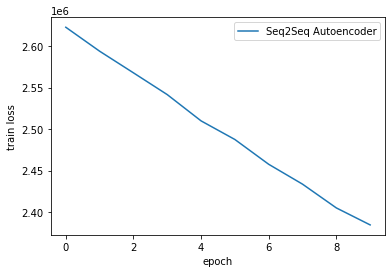

In [ ]:
sns.lineplot(x="epoch", y="train loss", data=results, label="Seq2Seq Autoencoder")

We define a function for printing out the true and predicted name of a file given its index.

In [ ]:
def print_prediction(model, idx):

    # Put model into evaluation mode
    model = model.eval().to("cuda")

    # Get X and y from test dataset given index
    X, y = test_dataset[idx]

    # Convert X to a batch of 1
    X_batch = X.unsqueeze(0)

    # Get likelihoods of each letter
    with torch.no_grad():
        predictions = model(X_batch.to("cuda")).cpu()
        # Choose the predicted letter with temperature
        p = torch.multinomial(F.softmax(predictions/0.75, dim=2).squeeze(), 1).squeeze()

    # Perform reverse vocab lookup
    subtokens = [IN_VOCAB_REV[i] for i in X.numpy()]
    filename = [OUT_VOCAB_REV[i] for i in y.numpy()]
    pred_filename = [OUT_VOCAB_REV[i] for i in p.numpy()]

    # Get rid of EOS and SOS tokens and join into string
    ignore_tokens = set([EOS, SOS, PAD])
    subtokens = ",".join([tok for tok in subtokens if tok not in ignore_tokens])
    filename = "".join([c for c in filename if c not in ignore_tokens])
    pred_filename = "".join([c for c in pred_filename if c not in ignore_tokens])

    # Print prediction
    print("File name:", filename)
    print("Predicted:", pred_filename)
    return

Here are some example predictions from the model. Unfortunately, it has not learned to predict filenames as well as we would like. The model usually predicts that file names end in .py, though it makes mistakes. It is accurate when predicting common python file names such as \__init__.py, decorators.py, and views.py. It also learned a few short common words such as test and get, and frequently places underscores and hyphens to separate these words from the remainder of the filenames. However, most of the other predicted characters in the file names are gibberish.

We believe that there are multiple factors that contribute to our model's performance. Predicting the name of a file is a difficult problem, even for a human. Many files could be adequately named different things, and it is difficult to summarize the meaning of a large program with just a word or two. If training data were available, it might be interesting to explore whether generating a longer caption instead of a file name has better performance.

We believe that the other factor that contributed to our model's inaccuracy was the way that we featurized the ASTs. By removing non-leaf nodes from the AST we lost important structural information about the program. We did this because the datapoints would be too long to fit in memory. This would force us to use a very small batch size and both the small batch size and the length of the datapoints would result in a very long training time.

In [ ]:
for i in range(100):
    print_prediction(seq2seq_model, i)
    print()

File name: tabs.py
Predicted: tebc..py

File name: local.py
Predicted: talertr.py

File name: zmq_receiver.py
Predicted: cemlrp..py

File name: vpnaas_tests.py
Predicted: gpnd_t_ssstt.p

File name: views.py
Predicted: qudre.py

File name: renderer.py
Predicted: dsslioo_.

File name: Config.py
Predicted: _tppetnpy

File name: digest.py
Predicted: scmves.py

File name: xmppserver.py
Predicted: papp.py

File name: define-profile-template.py
Predicted: dun-oots-oinspy

File name: get-address-pool.py
Predicted: gofarosmppy

File name: get-managed-sans.py
Predicted: get-deo---gi-isetpppyy

File name: get-storage-volume-template-policy.py
Predicted: ges-prsesk.yyy

File name: servers.py
Predicted: cetccoc.py

File name: validation.py
Predicted: gemclirepy

File name: sanetime.py
Predicted: cacaeeamcryip

File name: authorization.py
Predicted: modelerpyypp

File name: verbatim.py
Predicted: _t__pt_tapy

File name: views.py
Predicted: views.py

File name: proxy.py
Predicted: brrahep..p

File na

For improved results in the future, we would require additional GPUs with more memory. If we had access to this, we could potentially train on the full ASTs rather than just the leaf nodes. In addition, since the model has not yet converged, we could see improvement with additional training time.